In [ ]:
# Import statements

import subprocess
import os
import json
import joblib

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.display import display, Image, Markdown
from sklearn.metrics import classification_report


In [2]:
# Hardset vars
dataset_path = "data/processed/labeled_asset_dataset_enriched.csv"
config_path = "config/generation_params.json"

In [3]:
# Load the dataset for analysis, if it is not present, trigger a mlflow run using the default pipeline settings
try:
    df = pd.read_csv(dataset_path)
    print("✅ Dataset loaded.")
except FileNotFoundError:
    print(f"⚠️ {dataset_path} not found. Running MLflow pipeline to generate data...")
    result = subprocess.run(
        ["mlflow", "run", ".", "-e", "pipeline", "--env-manager=local"],
        capture_output=True, text=True, encoding="utf-8", errors="replace"
    )
    # Print the output, but ignore decode errors and replace weird chars
    print(result.stdout)
    if result.returncode != 0:
        print("❌ MLflow pipeline failed to run. Check the error above.")
        raise RuntimeError("MLflow pipeline execution failed")
    if os.path.exists(dataset_path):
        df = pd.read_csv(dataset_path)
        print("✅ Dataset generated and loaded.")
    else:
        raise FileNotFoundError(f"Dataset still not found at {dataset_path} after running pipeline.")

⚠️ data/processed/labeled_asset_dataset_enriched.csv not found. Running MLflow pipeline to generate data...
[DEBUG] Pipeline received config: config/generation_params.json
✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv
--- Model Report ---
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1965
           1       0.55      0.34      0.42       285

    accuracy                           0.88      2250
   macro avg       0.73      0.65      0.67      2250
weighted avg       0.86      0.88      0.87      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2103
           1       0.41      0.06      0.11       147

    accuracy                           0.93      2250
   macro avg       0.67      0.53      0.54      2250
weighted avg       0.90      0.93      0.91      2250


✅ Dataset generated and loaded.


In [4]:
# define a function to get the completeness stats
def run_completeness_test(present_both, total_assets, threshold=0.75, alpha=0.05):
    """Run a one-sample proportion z-test for completeness rate."""
    stat, p_value = sm.stats.proportions_ztest(
        count=present_both, 
        nobs=total_assets, 
        value=threshold, 
        alternative='larger'
    )
    return stat, p_value, p_value <= alpha

In [5]:
# define a function to evaluate model performance
def evaluate_model(report_path, model_name, benchmark_f1=0.80):
    """Evaluate model performance against the success benchmark."""
    if not os.path.exists(report_path):
        return {
            "model": model_name,
            "f1_score": None,
            "accuracy": None,
            "result": f"⚠️ No report found for {model_name}"
        }
    
    with open(report_path, "r") as f:
        report = json.load(f)
    
    f1_score = report["weighted avg"]["f1-score"]
    accuracy = report["accuracy"]
    result = "✅ Meets benchmark" if f1_score >= benchmark_f1 else "❌ Below benchmark"
    
    return {
        "model": model_name,
        "f1_score": f1_score,
        "accuracy": accuracy,
        "result": result
    }

In [6]:
def evaluate_scenario(stats, scenario_name, inventory_report, ipam_report):
    """Run completeness test and model evaluation for a given scenario."""
    # Completeness test
    z_stat, p_value, significant = run_completeness_test(stats["present_all"], stats["total_assets"])
    display(Markdown(f"""
    ### Completeness Statistical Test ({scenario_name})
    - **Null Hypothesis (H₀):** Completeness ≤ 75%  
    - **Alternative Hypothesis (H₁):** Completeness > 75%  
    - **Observed Completeness:** {stats['pct_all']:.2f}%  
    - **Z-statistic:** {z_stat:.4f}  
    - **P-value:** {p_value:.4e}  
    - **Alpha (α):** 0.05  
    - **Result:** {"✅ Reject H₀ – completeness is statistically significant." if significant else "❌ Fail to reject H₀ – completeness is not statistically significant."}
    """))

    # Model evaluation
    inventory_eval = evaluate_model(inventory_report, "Inventory Model")
    ipam_eval = evaluate_model(ipam_report, "IPAM Model")

    display(Markdown(f"""
    ### Predictive Model Evaluation ({scenario_name})

    | Model            | Accuracy | Weighted F1-Score | Result            |
    |------------------|----------|-------------------|-------------------|
    | {inventory_eval['model']} | {format_metric(inventory_eval['accuracy'], percent=True)} | {format_metric(inventory_eval['f1_score'])} | {inventory_eval['result']} |
    | {ipam_eval['model']}      | {format_metric(ipam_eval['accuracy'], percent=True)} | {format_metric(ipam_eval['f1_score'])} | {ipam_eval['result']} |

    **Benchmark:** F1-Score ≥ 0.80 required for success.
    """))

    # Display generated plots from the pipeline
    reports_dir = "reports"
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif')
    found_images = []

    for root, dirs, files in os.walk(reports_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                found_images.append(os.path.join(root, file))

    if found_images:
        display(Markdown(f"### Generated Report Images ({scenario_name})"))
        for img_path in found_images:
            rel_path = os.path.relpath(img_path, reports_dir)
            display(Markdown(f"**{rel_path}**"))
            display(Image(filename=img_path))
    else:
        print(f"No report images found in '{reports_dir}' for {scenario_name}.")

In [7]:
# Calculate presence rates
total_assets = len(df)
present_inventory = (df["missing_in_inventory"] == 0).sum()
present_ipam = (df["missing_in_ipam"] == 0).sum()
present_all = ((df["missing_in_inventory"] == 0) & (df["missing_in_ipam"] == 0)).sum()

In [8]:
# calculate percentages
pct_inventory = present_inventory / total_assets * 100
pct_ipam = present_ipam / total_assets * 100
pct_all = present_all / total_assets * 100

In [9]:
# save stats for default scenario to be used later in our 
default_stats = {
    "total_assets": total_assets,
    "present_inventory": present_inventory,
    "pct_inventory": pct_inventory,
    "present_ipam": present_ipam,
    "pct_ipam": pct_ipam,
    "present_all": present_all,
    "pct_all": pct_all
}

In [10]:
# Print high level stats of presence per system dataset
print(f"Total Observability Assets: {total_assets:,}")
print(f"Present in Inventory: {present_inventory:,} ({pct_inventory:.1f}%)")
print(f"Present in IPAM: {present_ipam:,} ({pct_ipam:.1f}%)")
print(f"Present in BOTH Inventory and IPAM: {present_all:,} ({pct_all:.1f}%)")

Total Observability Assets: 11,246
Present in Inventory: 9,820 (87.3%)
Present in IPAM: 10,512 (93.5%)
Present in BOTH Inventory and IPAM: 9,172 (81.6%)


In [11]:
# Print table form level stats of presence per system dataset
summary = pd.DataFrame({
    "Metric": ["Present in Inventory", "Present in IPAM", "Present in BOTH"],
    "Count": [present_inventory, present_ipam, present_all],
    "Percent": [pct_inventory, pct_ipam, pct_all]
})
display(summary)

,Metric,Count,Percent
0,Present in Inventory,9820,87.319936
1,Present in IPAM,10512,93.473235
2,Present in BOTH,9172,81.557887


In [12]:
# Run z-test for default scenario
z_stat, p_value, significant = run_completeness_test(default_stats["present_all"], default_stats["total_assets"])

display(Markdown(f"""
### Completeness Statistical Test (Default Scenario)
- **Null Hypothesis (H₀):** Completeness ≤ 75%  
- **Alternative Hypothesis (H₁):** Completeness > 75%  
- **Observed Completeness:** {default_stats['pct_all']:.2f}%  
- **Z-statistic:** {z_stat:.4f}  
- **P-value:** {p_value:.4e}  
- **Alpha (α):** 0.05  
- **Result:** {"✅ Reject H₀ – completeness is statistically significant." if significant else "❌ Fail to reject H₀ – completeness is not statistically significant."}
"""))


### Completeness Statistical Test (Default Scenario)
- **Null Hypothesis (H₀):** Completeness ≤ 75%  
- **Alternative Hypothesis (H₁):** Completeness > 75%  
- **Observed Completeness:** 81.56%  
- **Z-statistic:** 17.9318  
- **P-value:** 3.3275e-72  
- **Alpha (α):** 0.05  
- **Result:** ✅ Reject H₀ – completeness is statistically significant.


In [13]:
# Define report paths for both models
inventory_report_path = "reports/inventory/inventory_classification_report.json"
ipam_report_path = "reports/ipam/ipam_classification_report.json"

# Evaluate both models
inventory_eval = evaluate_model(inventory_report_path, "Inventory Model")
ipam_eval = evaluate_model(ipam_report_path, "IPAM Model")

# Display results in markdown with safe formatting
def format_metric(value, percent=False):
    """Safely format metrics for display."""
    if value is None:
        return "N/A"
    return f"{value:.2%}" if percent else f"{value:.2f}"

display(Markdown(f"""
### Predictive Model Evaluation (Inventory vs. IPAM)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| {inventory_eval['model']} | {format_metric(inventory_eval['accuracy'], percent=True)} | {format_metric(inventory_eval['f1_score'])} | {inventory_eval['result']} |
| {ipam_eval['model']}      | {format_metric(ipam_eval['accuracy'], percent=True)} | {format_metric(ipam_eval['f1_score'])} | {ipam_eval['result']} |

**Benchmark:** F1-Score ≥ 0.80 required for success.
"""))


### Predictive Model Evaluation (Inventory vs. IPAM)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| Inventory Model | 88.04% | 0.87 | ✅ Meets benchmark |
| IPAM Model      | 93.29% | 0.91 | ✅ Meets benchmark |

**Benchmark:** F1-Score ≥ 0.80 required for success.



    ### Completeness Statistical Test (Default Scenario)
    - **Null Hypothesis (H₀):** Completeness ≤ 75%  
    - **Alternative Hypothesis (H₁):** Completeness > 75%  
    - **Observed Completeness:** 81.56%  
    - **Z-statistic:** 17.9318  
    - **P-value:** 3.3275e-72  
    - **Alpha (α):** 0.05  
    - **Result:** ✅ Reject H₀ – completeness is statistically significant.
    


    ### Predictive Model Evaluation (Default Scenario)

    | Model            | Accuracy | Weighted F1-Score | Result            |
    |------------------|----------|-------------------|-------------------|
    | Inventory Model | 88.04% | 0.87 | ✅ Meets benchmark |
    | IPAM Model      | 93.29% | 0.91 | ✅ Meets benchmark |

    **Benchmark:** F1-Score ≥ 0.80 required for success.
    

### Generated Report Images (Default Scenario)

**inventory\inventory_feature_importance.png**

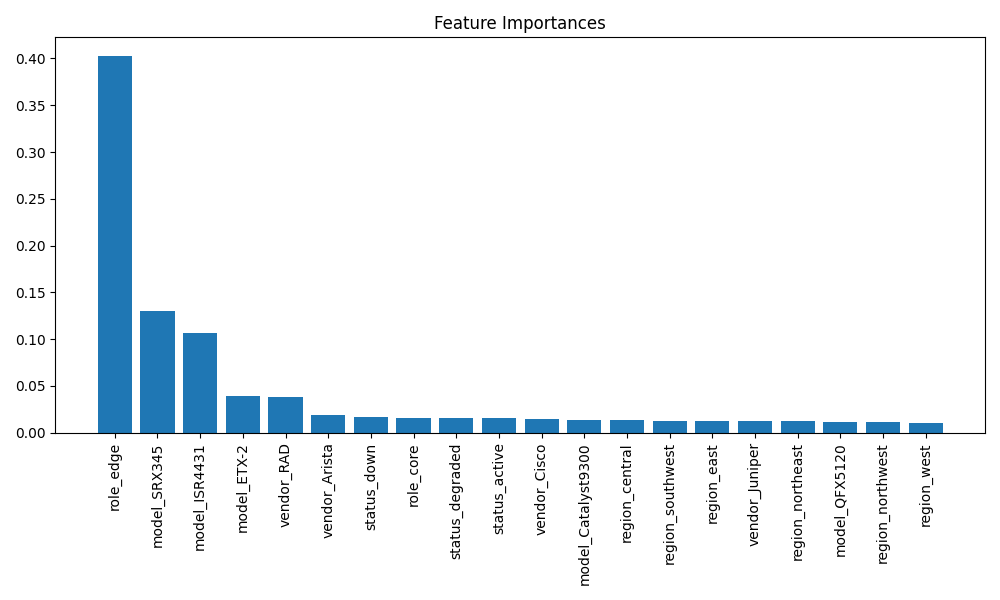

**ipam\ipam_feature_importance.png**

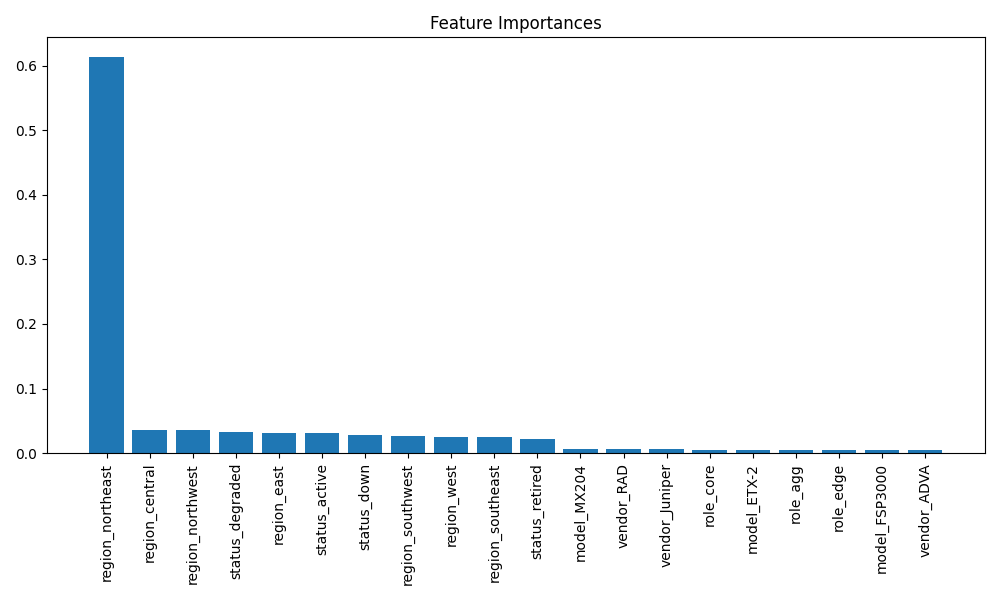

In [14]:
# Default scenario evaluation
evaluate_scenario(
    default_stats,
    "Default Scenario",
    "reports/inventory/inventory_classification_report.json",
    "reports/ipam/ipam_classification_report.json"
)

In [15]:
# Display the contents of the generation paramaters to display what failure rates were set at data generation
with open(config_path, "r") as f:
    params = json.load(f)

# Pretty-print as Markdown for notebook display
display(Markdown(f"### Contents of `{config_path}`:"))
display(Markdown(f"```json\n{json.dumps(params, indent=4)}\n```"))

### Contents of `config/generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.3,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.05,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.5,
        "SRX345": 0.6,
        "ETX-2": 0.4,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.1,
        "QFX5120": 0.05,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

### Generated Report Images

**inventory\inventory_feature_importance.png**

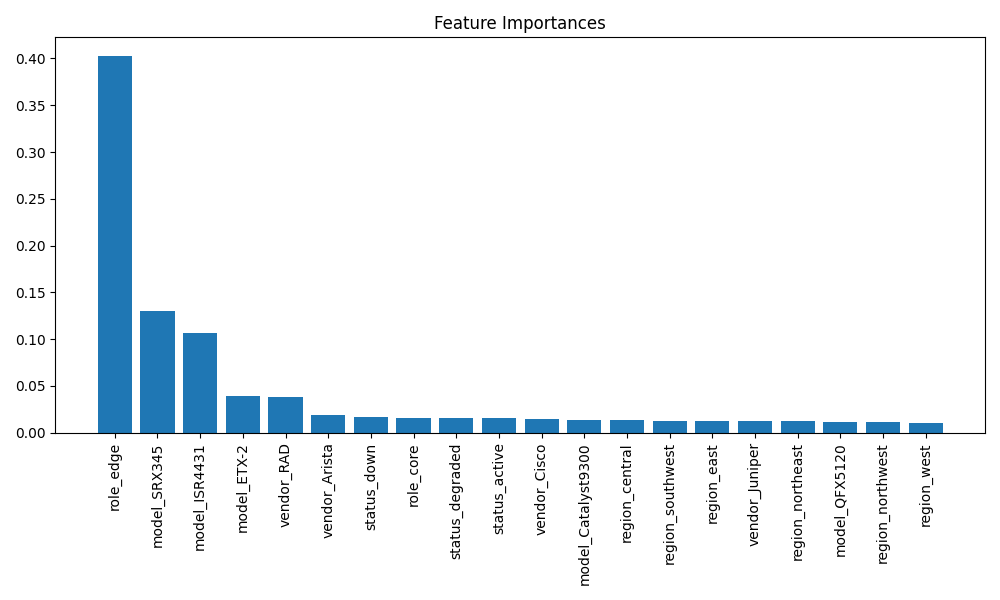

**ipam\ipam_feature_importance.png**

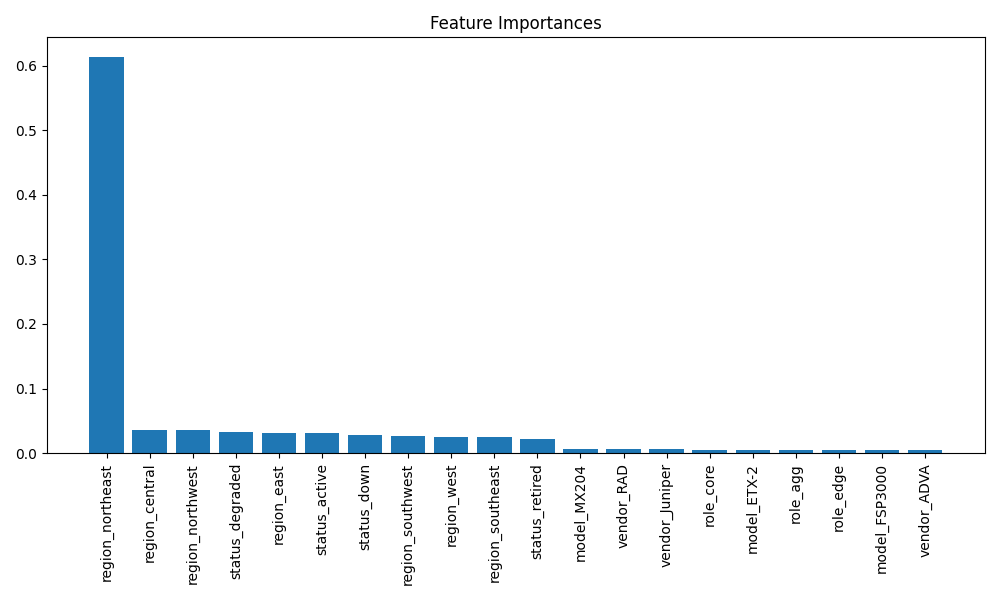

In [16]:
# Display all images in the reports directory (including subdirectories)
reports_dir = "reports"
image_extensions = ('.png', '.jpg', '.jpeg', '.gif')

found_images = []
for root, dirs, files in os.walk(reports_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            found_images.append(os.path.join(root, file))

if found_images:
    display(Markdown("### Generated Report Images"))
    for img_path in found_images:
        rel_path = os.path.relpath(img_path, reports_dir)
        display(Markdown(f"**{rel_path}**"))
        display(Image(filename=img_path))
else:
    print(f"No report images found in '{reports_dir}' or its subdirectories.")

# Conclusion

In [17]:
# calculated conclusion
default_conclusion_md = f"""
## Conclusion

This analysis confirms that the original asset presence rate across systems (before our alternative scenario showcase) {'meets' if default_stats['pct_all'] >= 75 else 'does not meet'} the 75% threshold required to proceed with the security audit project.  
Out of {default_stats['total_assets']:,} observability assets, {default_stats['present_inventory']:,} ({default_stats['pct_inventory']:.1f}%) were found in the Inventory system and {default_stats['present_ipam']:,} ({default_stats['pct_ipam']:.1f}%) were found in IPAM, with {default_stats['present_all']:,} assets ({default_stats['pct_all']:.1f}%) present in both systems.

Beyond validating data completeness, we leveraged a random forest supervised model to identify which asset characteristics most strongly drive missing records. With these insights, our team can now focus audit efforts on the specific processes, automation, or staff actions most likely to cause data gaps. This data-driven approach not only supports immediate project goals but also lays the groundwork for long-term improvements in asset data quality and system reliability.
"""

display(Markdown(default_conclusion_md))


## Conclusion

This analysis confirms that the original asset presence rate across systems (before our alternative scenario showcase) meets the 75% threshold required to proceed with the security audit project.  
Out of 11,246 observability assets, 9,820 (87.3%) were found in the Inventory system and 10,512 (93.5%) were found in IPAM, with 9,172 assets (81.6%) present in both systems.

Beyond validating data completeness, we leveraged a random forest supervised model to identify which asset characteristics most strongly drive missing records. With these insights, our team can now focus audit efforts on the specific processes, automation, or staff actions most likely to cause data gaps. This data-driven approach not only supports immediate project goals but also lays the groundwork for long-term improvements in asset data quality and system reliability.


# Analysis demonstrating alternative data generation scenarios

To validate that our ML model would make different predictions given different failures, we ran an alternative config to validate

In [18]:
# Adjusting input variables to alternative config settings
alt_config = "config/alt_scenario_generation_params.json"

In [19]:
# run the alternate training scenario with different config values
steps = [
    # Generate step with alternate config
    [
        "mlflow", "run", ".", "-e", "generate", "--env-manager=local",
        "-P", f"config={alt_config}"
    ],
    # Prepare step
    [
        "mlflow", "run", ".", "-e", "prepare", "--env-manager=local"
    ],
    # Train-both
    [
        "mlflow", "run", ".", "-e", "train-both", "--env-manager=local"
    ]
]

step_names = [
    "Generate (Alternate Config)",
    "Prepare",
    "Train Inventory",
    "Train IPAM",
    "Train Both"
]

for name, cmd in zip(step_names, steps):
    print(f"\n--- Running: {name} ---\n{' '.join(cmd)}\n")
    result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")
    print(result.stdout)
    if result.returncode != 0:
        print(f"❌ Step '{name}' failed. Check the output above.")
        break
    else:
        print(f"✅ Step '{name}' completed.\n")


--- Running: Generate (Alternate Config) ---
mlflow run . -e generate --env-manager=local -P config=config/alt_scenario_generation_params.json


✅ Step 'Generate (Alternate Config)' completed.


--- Running: Prepare ---
mlflow run . -e prepare --env-manager=local

✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv

✅ Step 'Prepare' completed.


--- Running: Train Inventory ---
mlflow run . -e train-both --env-manager=local

--- Model Report ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1828
           1       0.88      0.86      0.87       422

    accuracy                           0.95      2250
   macro avg       0.92      0.92      0.92      2250
weighted avg       0.95      0.95      0.95      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2066
           1       0.49      0.17      0.26       184

    accu

In [20]:
# Calculate new presence rates
df = pd.read_csv(dataset_path)

total_assets = len(df)
present_inventory = (df["missing_in_inventory"] == 0).sum()
present_ipam = (df["missing_in_ipam"] == 0).sum()
present_all = ((df["missing_in_inventory"] == 0) & (df["missing_in_ipam"] == 0)).sum()

In [21]:
# calculate new percentages
pct_inventory = present_inventory / total_assets * 100
pct_ipam = present_ipam / total_assets * 100
pct_all = present_all / total_assets * 100

In [22]:
# save the alt stats to be used in our findings

alt_stats = {
    "total_assets": total_assets,
    "present_inventory": present_inventory,
    "pct_inventory": pct_inventory,
    "present_ipam": present_ipam,
    "pct_ipam": pct_ipam,
    "present_all": present_all,
    "pct_all": pct_all
}

In [23]:
# Print new high level stats of presence per system dataset
print(f"Total Observability Assets: {total_assets:,}")
print(f"Present in Inventory: {present_inventory:,} ({pct_inventory:.1f}%)")
print(f"Present in IPAM: {present_ipam:,} ({pct_ipam:.1f}%)")
print(f"Present in BOTH Inventory and IPAM: {present_all:,} ({pct_all:.1f}%)")

Total Observability Assets: 11,246
Present in Inventory: 9,136 (81.2%)
Present in IPAM: 10,326 (91.8%)
Present in BOTH Inventory and IPAM: 8,393 (74.6%)


In [24]:
# Print new table form level stats of presence per system dataset
summary = pd.DataFrame({
    "Metric": ["Present in Inventory", "Present in IPAM", "Present in BOTH"],
    "Count": [present_inventory, present_ipam, present_all],
    "Percent": [pct_inventory, pct_ipam, pct_all]
})
display(summary)

,Metric,Count,Percent
0,Present in Inventory,9136,81.237773
1,Present in IPAM,10326,91.819314
2,Present in BOTH,8393,74.630980


In [25]:
# Run z-test for alternative scenario
z_stat_alt, p_value_alt, significant_alt = run_completeness_test(alt_stats["present_all"], alt_stats["total_assets"])

display(Markdown(f"""
### Completeness Statistical Test (Alternative Scenario)
- **Null Hypothesis (H₀):** Completeness ≤ 75%  
- **Alternative Hypothesis (H₁):** Completeness > 75%  
- **Observed Completeness:** {alt_stats['pct_all']:.2f}%  
- **Z-statistic:** {z_stat_alt:.4f}  
- **P-value:** {p_value_alt:.4e}  
- **Alpha (α):** 0.05  
- **Result:** {"✅ Reject H₀ – completeness is statistically significant." if significant_alt else "❌ Fail to reject H₀ – completeness is not statistically significant."}
"""))


### Completeness Statistical Test (Alternative Scenario)
- **Null Hypothesis (H₀):** Completeness ≤ 75%  
- **Alternative Hypothesis (H₁):** Completeness > 75%  
- **Observed Completeness:** 74.63%  
- **Z-statistic:** -0.8994  
- **P-value:** 8.1577e-01  
- **Alpha (α):** 0.05  
- **Result:** ❌ Fail to reject H₀ – completeness is not statistically significant.


In [26]:
# Define report paths for both models
inventory_report_path = "reports/inventory/inventory_classification_report.json"
ipam_report_path = "reports/ipam/ipam_classification_report.json"

# Evaluate both models
inventory_eval = evaluate_model(inventory_report_path, "Inventory Model")
ipam_eval = evaluate_model(ipam_report_path, "IPAM Model")

# Display results in markdown with safe formatting
def format_metric(value, percent=False):
    """Safely format metrics for display."""
    if value is None:
        return "N/A"
    return f"{value:.2%}" if percent else f"{value:.2f}"

display(Markdown(f"""
### Predictive Model Evaluation (Inventory vs. IPAM)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| {inventory_eval['model']} | {format_metric(inventory_eval['accuracy'], percent=True)} | {format_metric(inventory_eval['f1_score'])} | {inventory_eval['result']} |
| {ipam_eval['model']}      | {format_metric(ipam_eval['accuracy'], percent=True)} | {format_metric(ipam_eval['f1_score'])} | {ipam_eval['result']} |

**Benchmark:** F1-Score ≥ 0.80 required for success.
"""))


### Predictive Model Evaluation (Inventory vs. IPAM)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| Inventory Model | 95.24% | 0.95 | ✅ Meets benchmark |
| IPAM Model      | 91.78% | 0.90 | ✅ Meets benchmark |

**Benchmark:** F1-Score ≥ 0.80 required for success.



    ### Completeness Statistical Test (Alternative Scenario)
    - **Null Hypothesis (H₀):** Completeness ≤ 75%  
    - **Alternative Hypothesis (H₁):** Completeness > 75%  
    - **Observed Completeness:** 74.63%  
    - **Z-statistic:** -0.8994  
    - **P-value:** 8.1577e-01  
    - **Alpha (α):** 0.05  
    - **Result:** ❌ Fail to reject H₀ – completeness is not statistically significant.
    


    ### Predictive Model Evaluation (Alternative Scenario)

    | Model            | Accuracy | Weighted F1-Score | Result            |
    |------------------|----------|-------------------|-------------------|
    | Inventory Model | 95.24% | 0.95 | ✅ Meets benchmark |
    | IPAM Model      | 91.78% | 0.90 | ✅ Meets benchmark |

    **Benchmark:** F1-Score ≥ 0.80 required for success.
    

### Generated Report Images (Alternative Scenario)

**inventory\inventory_feature_importance.png**

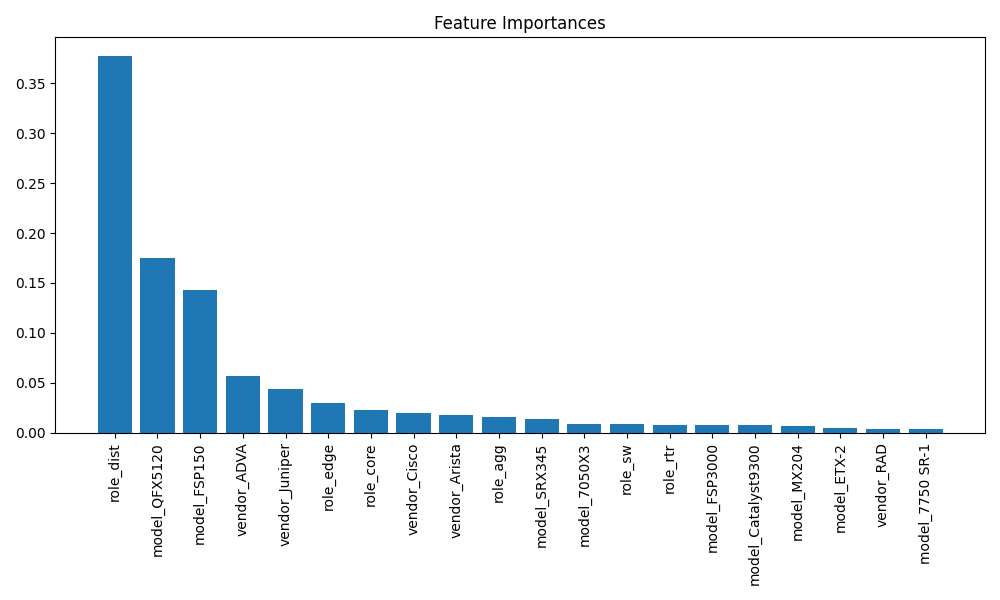

**ipam\ipam_feature_importance.png**

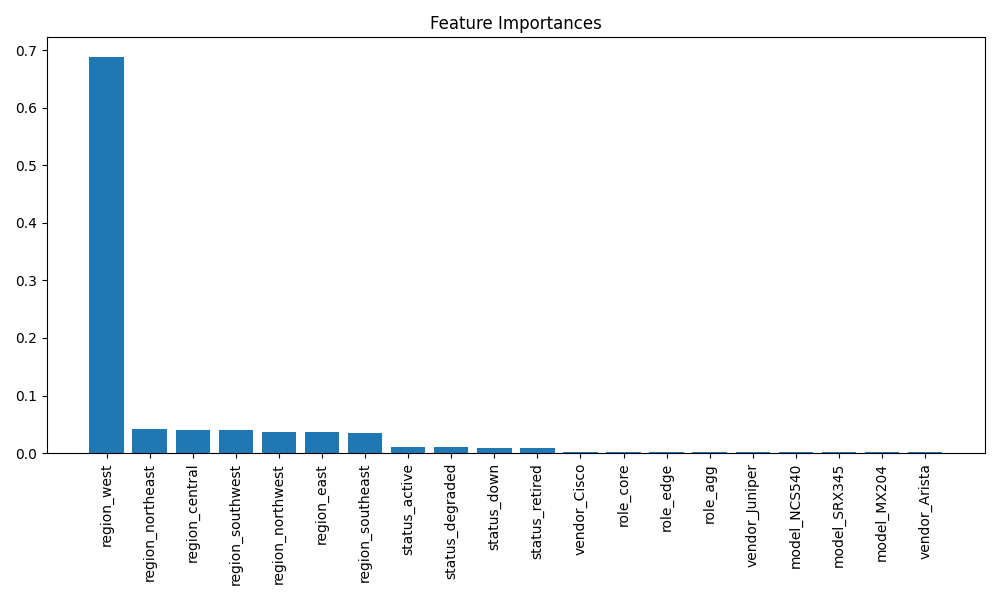

In [27]:
# Alternative scenario evaluation
evaluate_scenario(
    alt_stats,
    "Alternative Scenario",
    "reports/inventory/inventory_classification_report.json",
    "reports/ipam/ipam_classification_report.json"
)

In [28]:
# Display the contents of the generation paramaters to display what failure rates were set at data generation with the alternet scenario configuration
with open(alt_config, "r") as f:
    params = json.load(f)

# Pretty-print as Markdown for notebook display
display(Markdown(f"### Contents of `{alt_config}`:"))
display(Markdown(f"```json\n{json.dumps(params, indent=4)}\n```"))

### Contents of `config/alt_scenario_generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.01,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.45,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.01,
        "SRX345": 0.03,
        "ETX-2": 0.02,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.87,
        "QFX5120": 0.91,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

### Generated Report Images

**inventory\inventory_feature_importance.png**

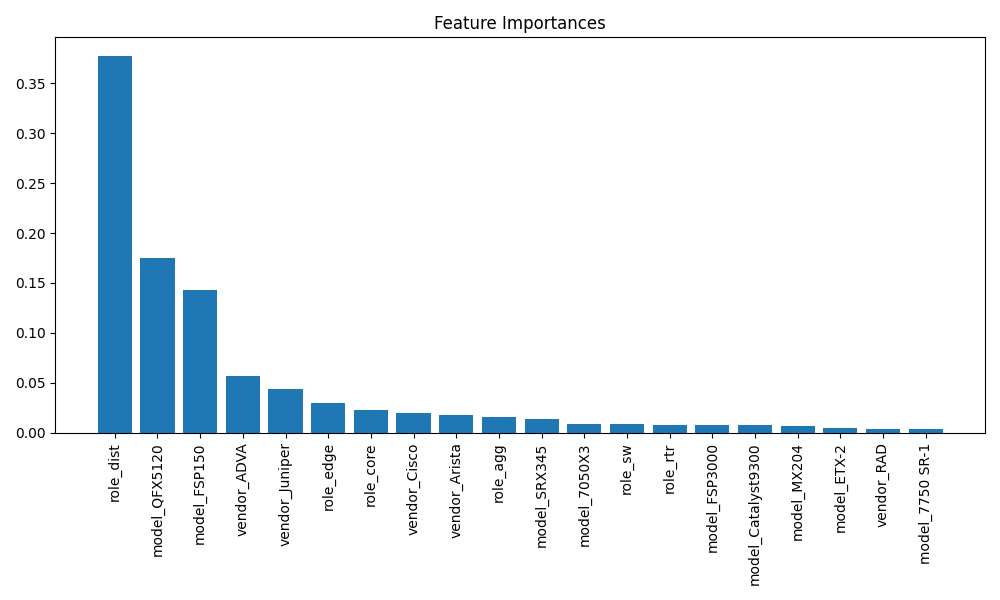

**ipam\ipam_feature_importance.png**

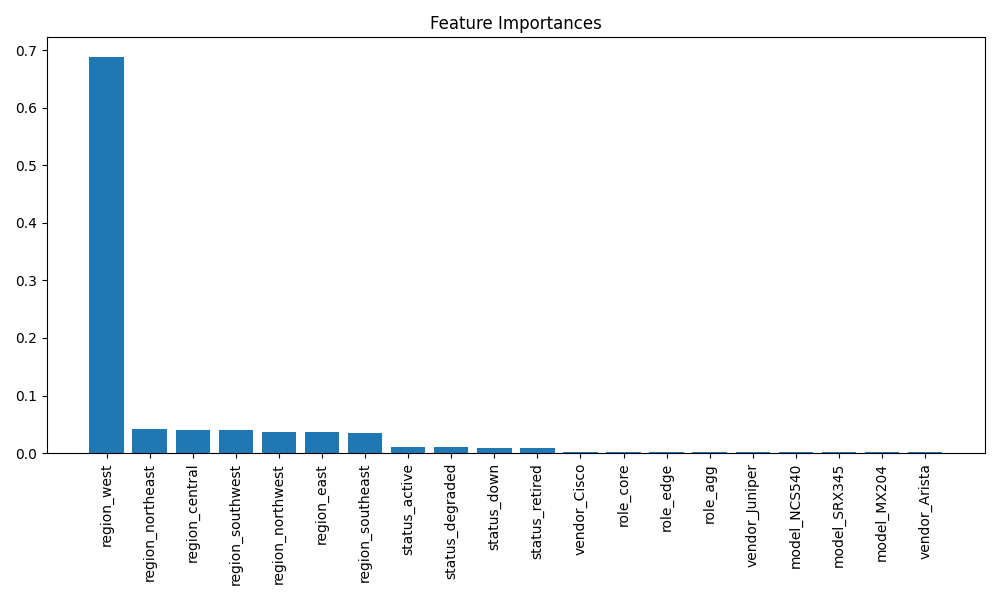

In [29]:
# Display all images in the reports directory (including subdirectories)
reports_dir = "reports"
image_extensions = ('.png', '.jpg', '.jpeg', '.gif')

found_images = []
for root, dirs, files in os.walk(reports_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            found_images.append(os.path.join(root, file))

if found_images:
    display(Markdown("### Generated Report Images"))
    for img_path in found_images:
        rel_path = os.path.relpath(img_path, reports_dir)
        display(Markdown(f"**{rel_path}**"))
        display(Image(filename=img_path))
else:
    print(f"No report images found in '{reports_dir}' or its subdirectories.")

In [30]:
# Dynamic Markdown Generator
alt_scenario_md = f"""
## Alternative Conclusion

In this scenario, the proportion of assets present in both Inventory and IPAM falls to {alt_stats['pct_all']:.1f}%, {'just below' if alt_stats['pct_all'] < 75 else 'above'} the critical 75% threshold ({alt_stats['present_inventory']:,} present in Inventory, {alt_stats['present_ipam']:,} in IPAM, and {alt_stats['present_all']:,} in both, out of {alt_stats['total_assets']:,} observability assets). This triggers the need for targeted intervention before proceeding with the security audit.

By leveraging the insights from our predictive model, we can rapidly pinpoint which asset characteristics and operational factors are most strongly associated with missing records. This enables us to close the loop with actionable steps—such as reviewing staff workflows, updating automation logic, or focusing on specific device roles or regions—ensuring data quality issues are addressed efficiently.

This action cycle, powered by model-driven analytics, turns each audit into an opportunity for iterative improvement, strengthening both data reliability and operational readiness for future initiatives.
"""

display(Markdown(alt_scenario_md))


## Alternative Conclusion

In this scenario, the proportion of assets present in both Inventory and IPAM falls to 74.6%, just below the critical 75% threshold (9,136 present in Inventory, 10,326 in IPAM, and 8,393 in both, out of 11,246 observability assets). This triggers the need for targeted intervention before proceeding with the security audit.

By leveraging the insights from our predictive model, we can rapidly pinpoint which asset characteristics and operational factors are most strongly associated with missing records. This enables us to close the loop with actionable steps—such as reviewing staff workflows, updating automation logic, or focusing on specific device roles or regions—ensuring data quality issues are addressed efficiently.

This action cycle, powered by model-driven analytics, turns each audit into an opportunity for iterative improvement, strengthening both data reliability and operational readiness for future initiatives.
